# Zaawansowane wizualizacje sygnału EKG

XD

In [13]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
filename = "z4data.pkl"

with open(filename, "rb") as f:
    data = pickle.load(f)

ecg = data['ECG_Clean']
watch = data['Watch_Clean']
ecg_full = data["ECG"]
watch_full = data["Watch"]
FS = data['fs']

print(ecg, len(ecg)) # okna ekg
print(watch, len(watch)) # dane z zegarka
print(FS) #  czestotliwosc probkowania

new_ecg = []
for i in range(len(ecg)):
    new_ecg.append(pd.DataFrame(data=ecg[i], columns = ['I', 'II', 'III', 'avR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']))
ecg = new_ecg



[[[ 8.16349012e+00  6.57258773e+00 -1.64109082e+00 ... -1.59284179e-01
    7.98438342e+00  5.73122413e+00]
  [ 6.90041002e+01  7.14308276e+01  1.42262150e+00 ...  1.66664741e+02
    9.09082744e+01  5.33766986e+01]
  [ 8.66463390e+01  7.66520816e+01 -1.12190737e+01 ...  2.00963487e+02
    1.01568735e+02  7.03010615e+01]
  ...
  [-2.69267927e+01 -8.90885790e+01 -6.12055470e+01 ... -4.65280546e+01
   -6.62417097e+01 -5.89823755e+01]
  [-5.46599546e+00 -8.52994538e+01 -7.97615484e+01 ... -3.59774714e+01
   -3.32567093e+01 -1.97756772e+01]
  [ 2.16180577e+01 -7.42100587e+01 -9.66602650e+01 ... -2.73707866e+01
   -2.31902546e+01 -2.59167817e+01]]

 [[-2.76898510e+02  2.03320630e+03  2.31276131e+03 ... -1.88631320e+02
    1.78721300e+02  1.84496018e+02]
  [-3.81787496e+02  1.27618184e+03  1.66226354e+03 ... -9.61754427e+02
   -3.82374726e+02 -1.36190968e+02]
  [-2.98468812e+02  2.39223659e+02  5.41375525e+02 ... -1.12788083e+03
   -6.07731163e+02 -2.83855827e+02]
  ...
  [ 3.19551233e+00 -1.3

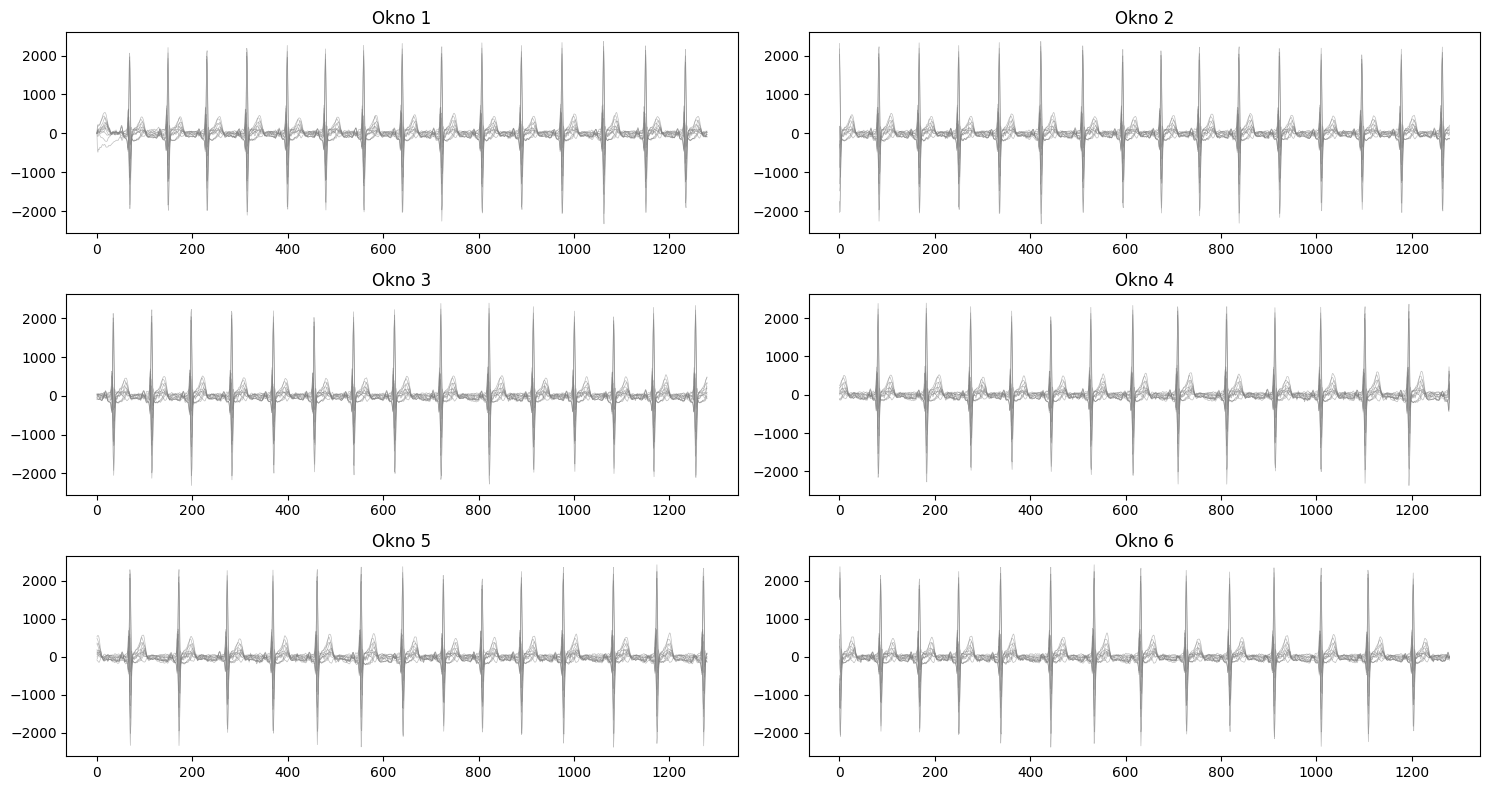

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

for idx, window in enumerate(ecg[:6]):
    ax = axes.flatten()[idx]
    ax.plot(window, color='gray', alpha=0.5, linewidth=0.5)
    ax.set_title(f"Okno {idx + 1}")

plt.tight_layout()
plt.show()

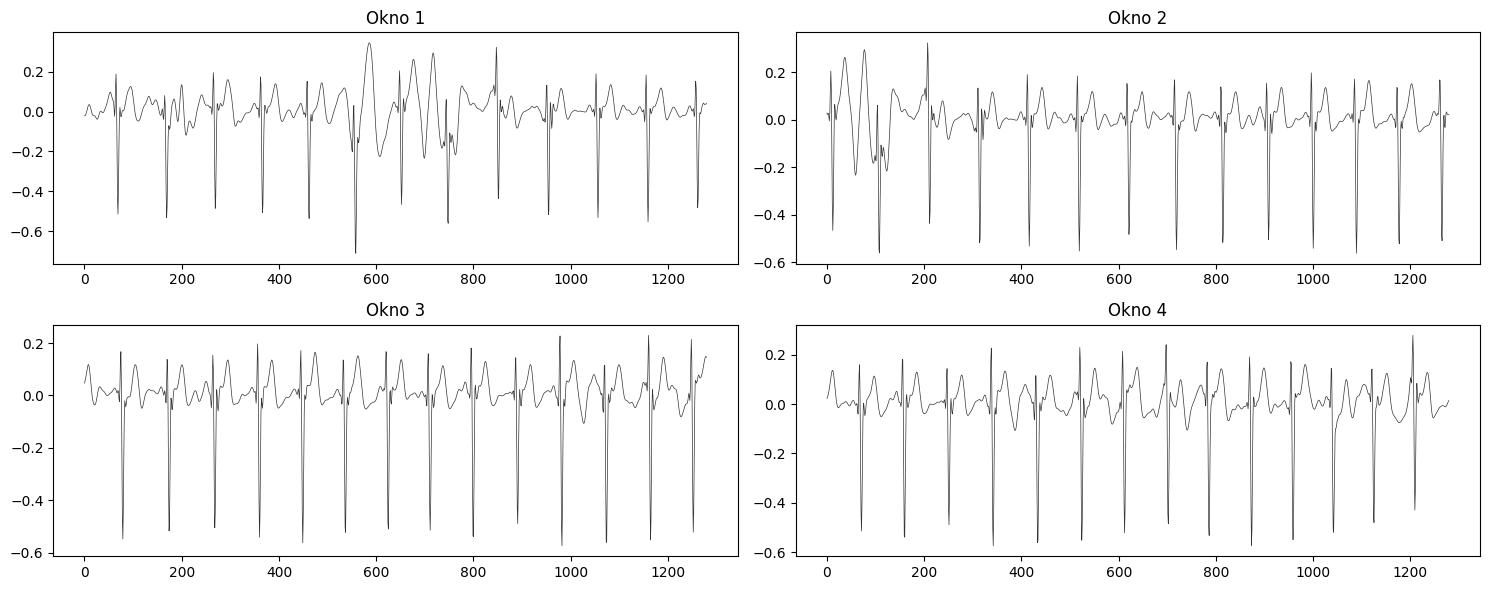

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

for i in range(4):
    ax = axes.flatten()[i]
    ax.plot(watch[i], color='black', alpha=0.8, linewidth=0.5)
    ax.set_title(f"Okno {i + 1}")


plt.tight_layout()
plt.show()

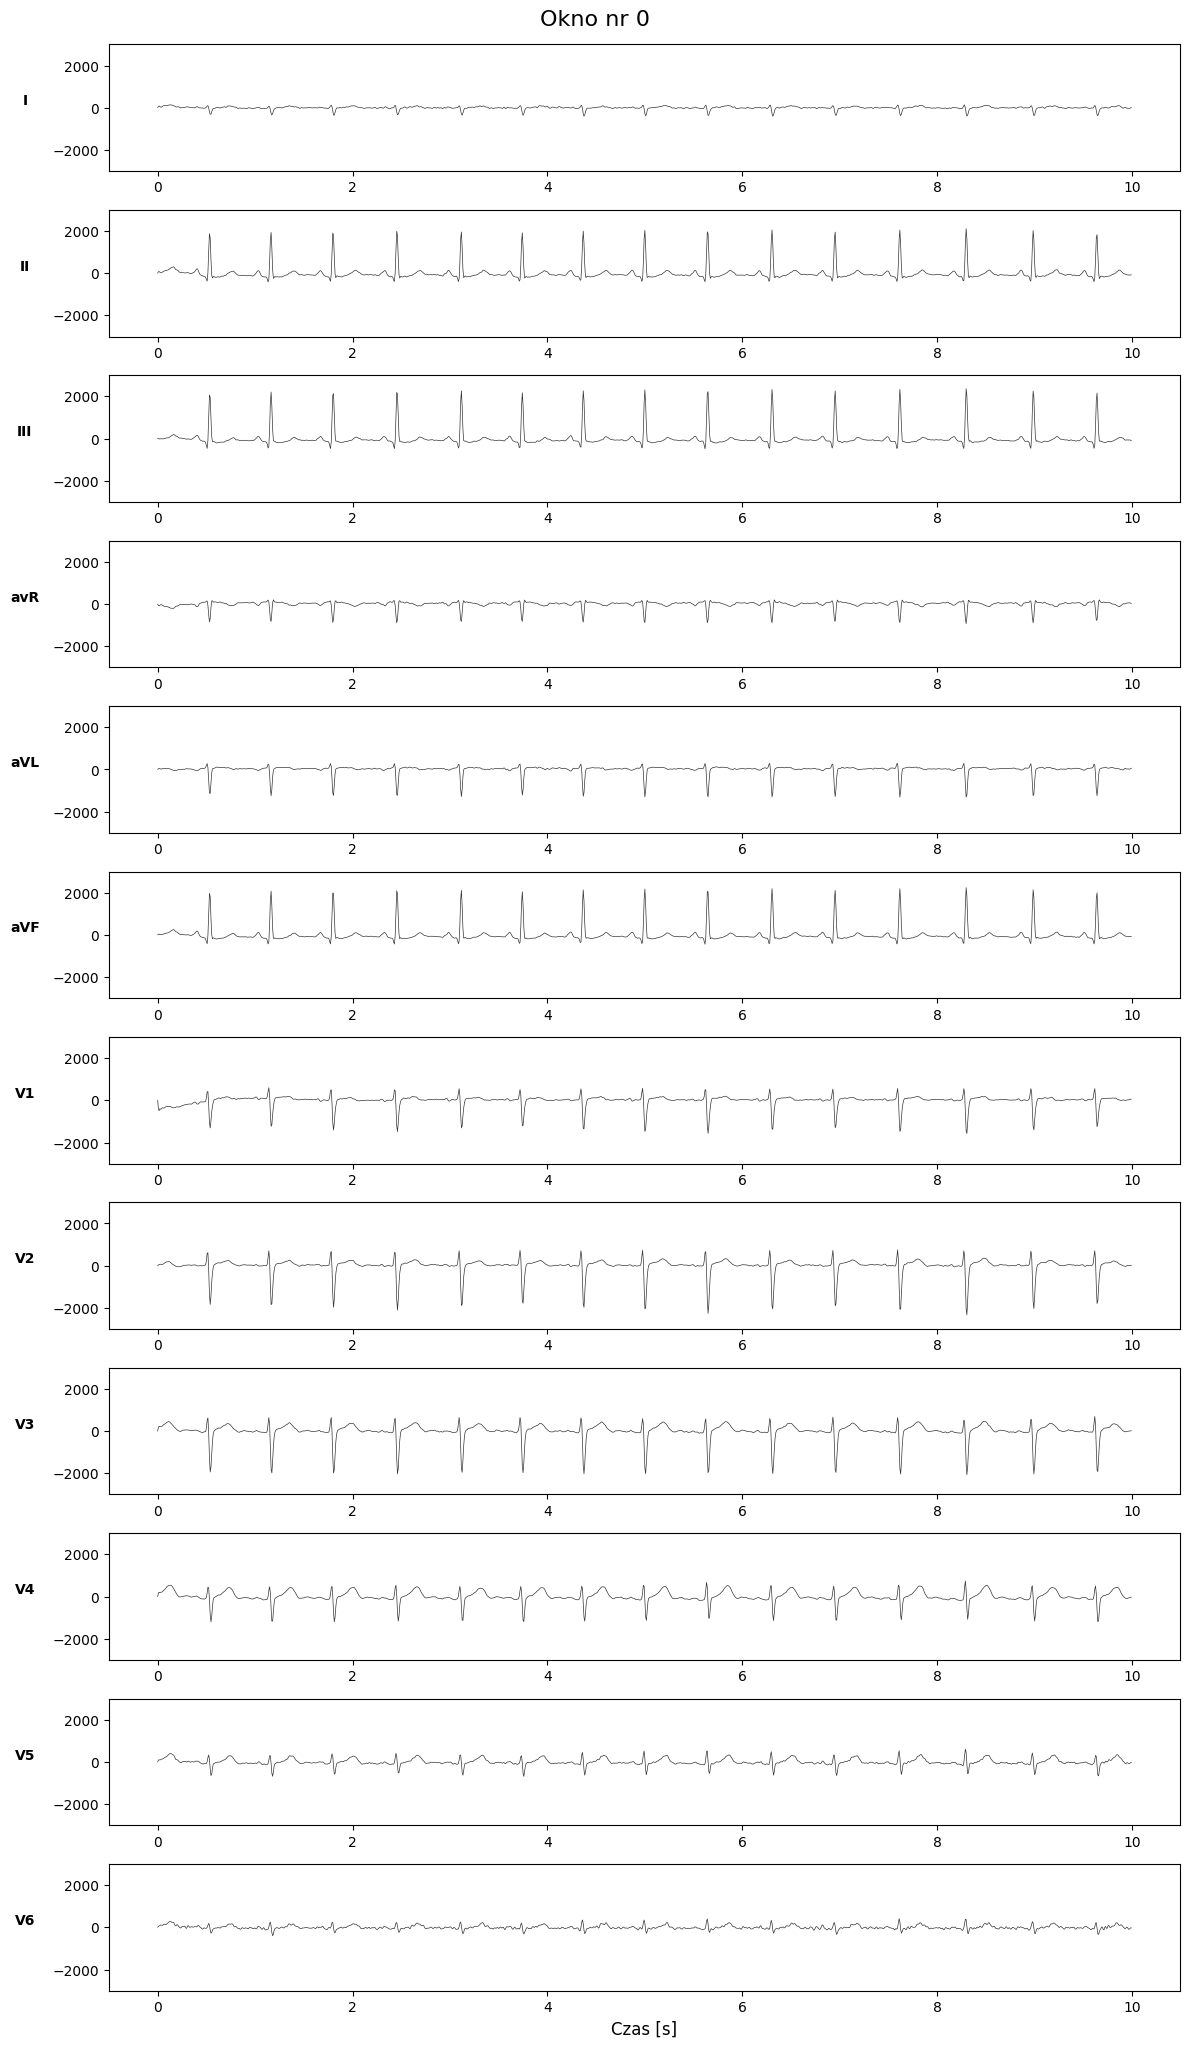

In [16]:
channels = ['I', 'II', 'III', 'avR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

first_window_index = 0

def show_window_channels(window_index, channels):
    window = ecg[window_index]
    size = len(channels)
    fig, axes = plt.subplots(nrows = size, ncols=1, figsize=(12, 20))
    time_axis = np.arange(window.shape[0]) / FS

    plt.setp(axes, ylim=(-3000, 3000))

    for idx, channel in enumerate(channels):
        signal = window.iloc[:, idx]
        ax = axes.flatten()[idx]
        ax.plot(time_axis, signal, color='black', alpha=0.8, linewidth=0.5)
        ax.set_ylabel(channel, rotation=0, labelpad=20, fontweight='bold')
    
    plt.tight_layout()
    plt.xlabel("Czas [s]", fontsize=12)
    plt.suptitle(f"Okno nr {window_index}", y=1.01, fontsize=16)
    plt.show()
    
show_window_channels(first_window_index, channels)

    

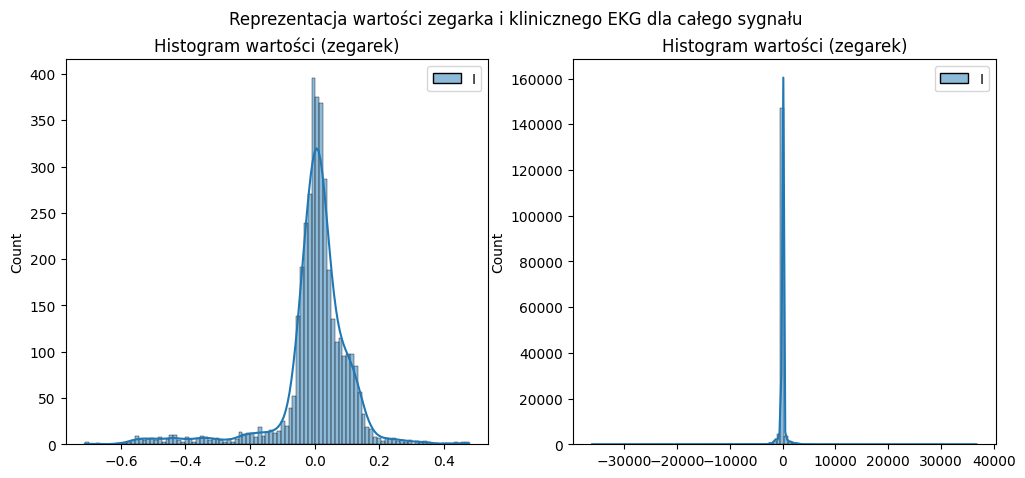

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle("Reprezentacja wartości zegarka i klinicznego EKG dla całego sygnału", fontsize=12)

sns.histplot(watch_full, bins=100, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Histogram wartości (zegarek)')

sns.histplot(ecg_full.iloc[:, [0]], bins=100, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Histogram wartości (zegarek)')

plt.show()

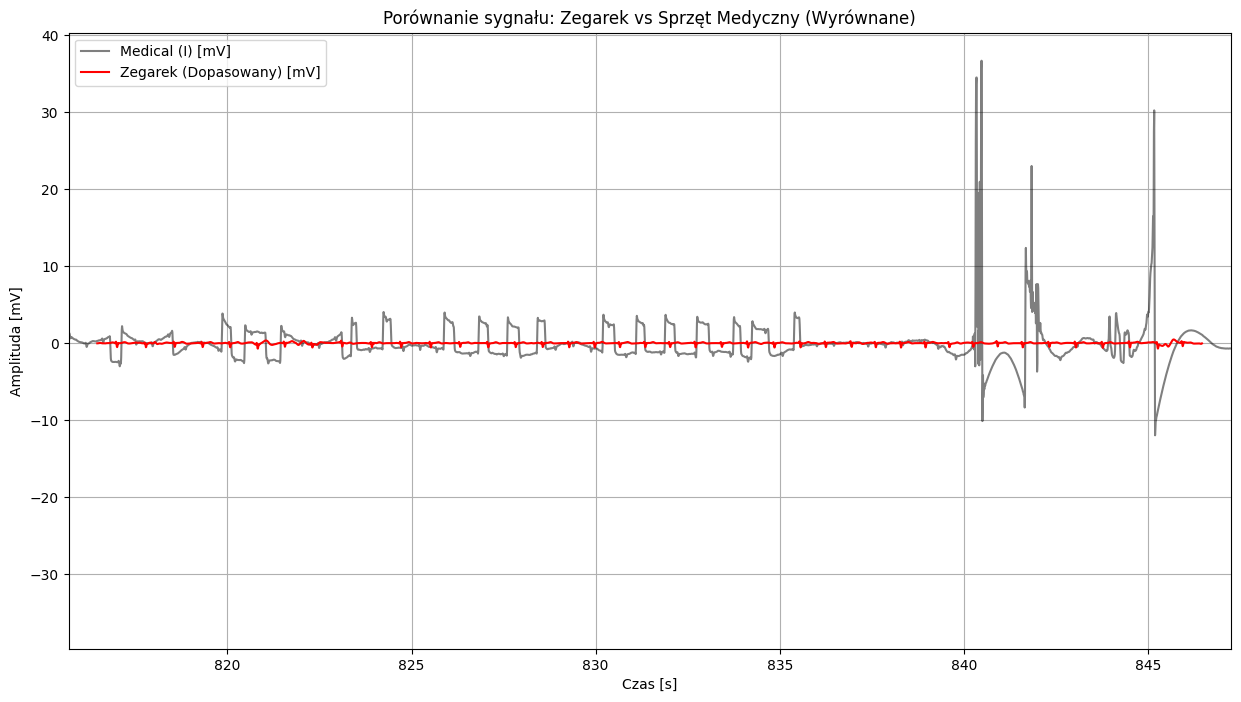

In [18]:
from scipy.signal import correlate

def align_watch_vs_medical(medical_data, watch_data, csv_fs, watch_fs, lead_csv='I', start = 0, end = -1):
    
    if end == -1:
        end = len(medical_data)

    sig_long = medical_data[lead_csv].values.flatten()
    
    sig_short = watch_data["I"].values.flatten()

    #zamiana jednostek
    sig_long = sig_long / 1000

    long_centered = sig_long - np.mean(sig_long)
    short_centered = sig_short - np.mean(sig_short)
    
    corr = correlate(long_centered, short_centered, mode='valid')
    best_idx = np.argmax(corr)

    plt.figure(figsize=(15, 8))
    
    t_long = np.arange(len(sig_long)) / 128
    t_short = (np.arange(len(sig_short)) + best_idx) / 128
    
    plt.plot(t_long, sig_long, color='black', alpha=0.5, label=f'Medical ({lead_csv}) [mV]')
    plt.plot(t_short, sig_short, color='red', linewidth=1.5, label='Zegarek (Dopasowany) [mV]')
    
    plt.xlim((best_idx - 100)/128, (best_idx + len(sig_short) + 100)/128)
    
    plt.title("Porównanie sygnału: Zegarek vs Sprzęt Medyczny (Wyrównane)")
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda [mV]")
    plt.legend()
    plt.grid(True)
    plt.show()



align_watch_vs_medical(ecg_full, watch_full, csv_fs=500, watch_fs=128, lead_csv='I')

UWAGA: Używam DANYCH WZORNIKOWYCH do demonstracji, ponieważ clean_df lub clean_df_watch nie są zdefiniowane.


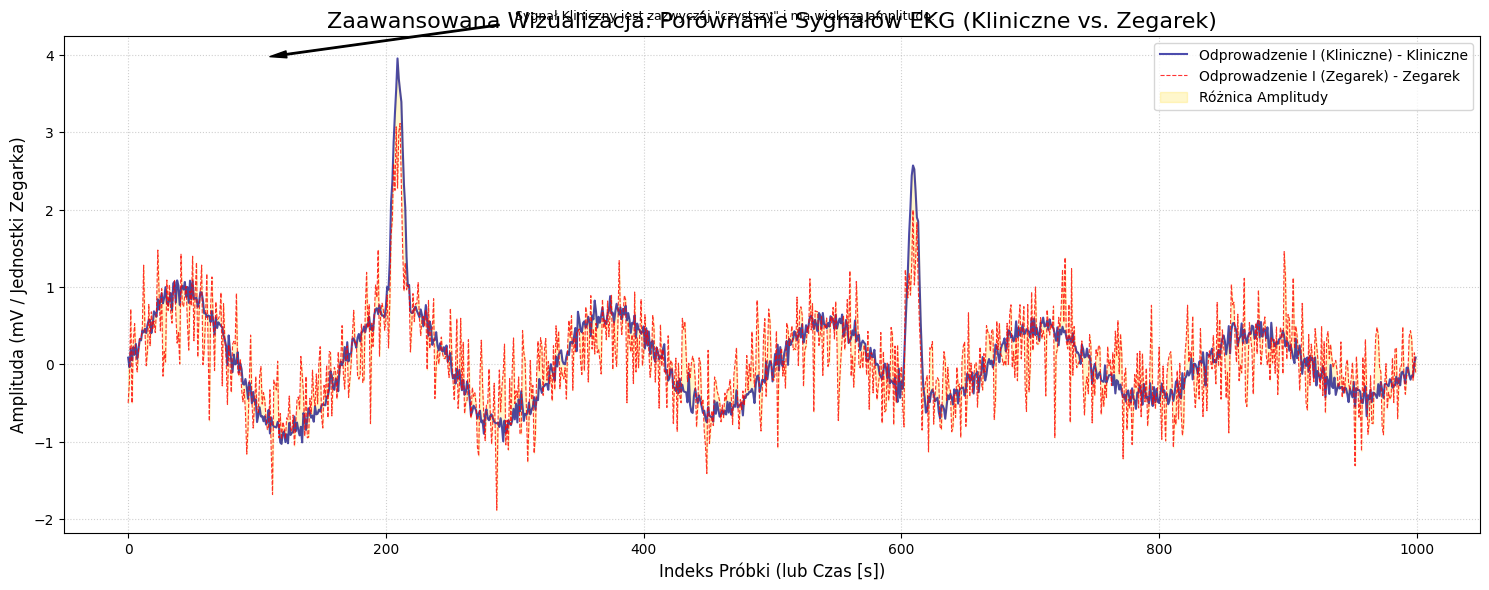

In [19]:

try:
    # Zakładam, że clean_df i clean_df_watch są już wczytane
    # i clean_df ma co najmniej 1 kolumnę, a clean_df_watch ma 1 kolumnę.
    clinic_ecg = clean_df.iloc[:, 0]  # Odprowadzenie 1 (pierwsza kolumna)
    watch_ecg = clean_df_watch.iloc[:, 0] # Odprowadzenie z zegarka (pierwsza kolumna)
except NameError:
    print("UWAGA: Używam DANYCH WZORNIKOWYCH do demonstracji, ponieważ clean_df lub clean_df_watch nie są zdefiniowane.")
    # Tworzenie przykładowych danych dla demonstracji
    n_samples = 1000  # Liczba próbek
    t = np.linspace(0, 5, n_samples, endpoint=False) # Oś czasu
    
    # Symulacja sygnału EKG (sinusoida z szumem i 'pikiem' QRS)
    clinic_ecg = np.sin(2 * np.pi * 1.2 * t) * np.exp(-t/5) + 0.1 * np.random.randn(n_samples)
    clinic_ecg[200:220] += np.hanning(20) * 3 # Symulacja piku QRS
    clinic_ecg[600:620] += np.hanning(20) * 3
    
    # Symulacja sygnału z zegarka (często ma mniejszą amplitudę i jest głośniejszy/różny)
    watch_ecg = clinic_ecg * 0.7 + 0.4 * np.random.randn(n_samples)
    
    # Konwersja na Serie (jak w przypadku DataFrame.iloc[:, 0])
    clinic_ecg = pd.Series(clinic_ecg, name='Odprowadzenie I (Kliniczne)')
    watch_ecg = pd.Series(watch_ecg, name='Odprowadzenie I (Zegarek)')


# --- 2. Wyrównanie Długości Sygnałów ---
# W praktyce sygnały mogą mieć różną długość. Wyrównajmy je do krótszego.
min_len = min(len(clinic_ecg), len(watch_ecg))

clinic_ecg = clinic_ecg[:min_len]
watch_ecg = watch_ecg[:min_len]

# Oś X (może być czasem, jeśli znamy częstotliwość próbkowania)
x_axis = np.arange(min_len) # Indeksy próbek jako oś X

# --- 3. Wizualizacja ---

plt.figure(figsize=(15, 6))

# Wykres Klinicznego EKG - Jako Podstawa
plt.plot(x_axis, clinic_ecg, 
         label=f'{clinic_ecg.name} - Kliniczne', 
         color='darkblue', 
         linewidth=1.5,
         alpha=0.7)

# Wykres EKG z Zegarka - Naniesiony
# Zazwyczaj sygnał z zegarka jest skalowany (np. by pokazać różnice w amplitudzie)
# Pamiętaj, że offset i skalowanie mogą być konieczne w zależności od danych!
# W tym przykładzie, aby lepiej pokazać nałożenie, użyję innej stylistyki.
plt.plot(x_axis, watch_ecg, 
         label=f'{watch_ecg.name} - Zegarek', 
         color='red', 
         linestyle='--',
         linewidth=0.8,
         alpha=0.8)

# Dodanie Wypełnienia (opcjonalne, ale dodaje czytelności w zaawansowanej wizualizacji)
plt.fill_between(x_axis, clinic_ecg, watch_ecg, 
                 color='gold', 
                 alpha=0.2, 
                 label='Różnica Amplitudy')

# Ustawienia Wykresu
plt.title('Zaawansowana Wizualizacja: Porównanie Sygnałów EKG (Kliniczne vs. Zegarek)', fontsize=16)
plt.xlabel('Indeks Próbki (lub Czas [s])', fontsize=12)
plt.ylabel('Amplituda (mV / Jednostki Zegarka)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

# Dodanie adnotacji (np. o różnicach)
plt.annotate('Sygnał Kliniczny jest zazwyczaj "czystszy" i ma większą amplitudę.', 
             xy=(x_axis[int(min_len*0.1)], clinic_ecg.max()), 
             xytext=(x_axis[int(min_len*0.3)], clinic_ecg.max() + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=9)

plt.tight_layout()
plt.show()

Aby przeprowadzić analizę pasma i amplitudy sygnałów oraz ich wizualizację, konieczne jest przede wszystkim przeniesienie opisu sygnału z dziedziny czasu do dziedziny częstotliwości. Kluczowym narzędziem do tego celu jest transformata Fouriera, a zwłaszcza jej dyskretna wersja (dla sygnałów cyfrowych) – dyskretna transformata Fouriera (DFT) lub, częściej, wydajna obliczeniowo szybka transformata Fouriera (FFT).

Ważne aby sygnał był spróbkowany z częstotliwością $f_s​$ większą niż podwójna maksymalna częstotliwość składowa sygnału - kryterium Nyquista: 

$f_s\geq2f_{max}$​

Z racji analizy skończonego fragmentu sygnału należy zminimalizować efekt wycieku widmowego (spectral leakage) wynikający z nagłego ucięcia sygnału, stosuje się funkcje okna (np. prostokątne, Hamminga, Hanninga). Pomnożenie sygnału przez funkcję okna sprawia, że jego wartość na brzegach analizowanego bloku dąży do zera.

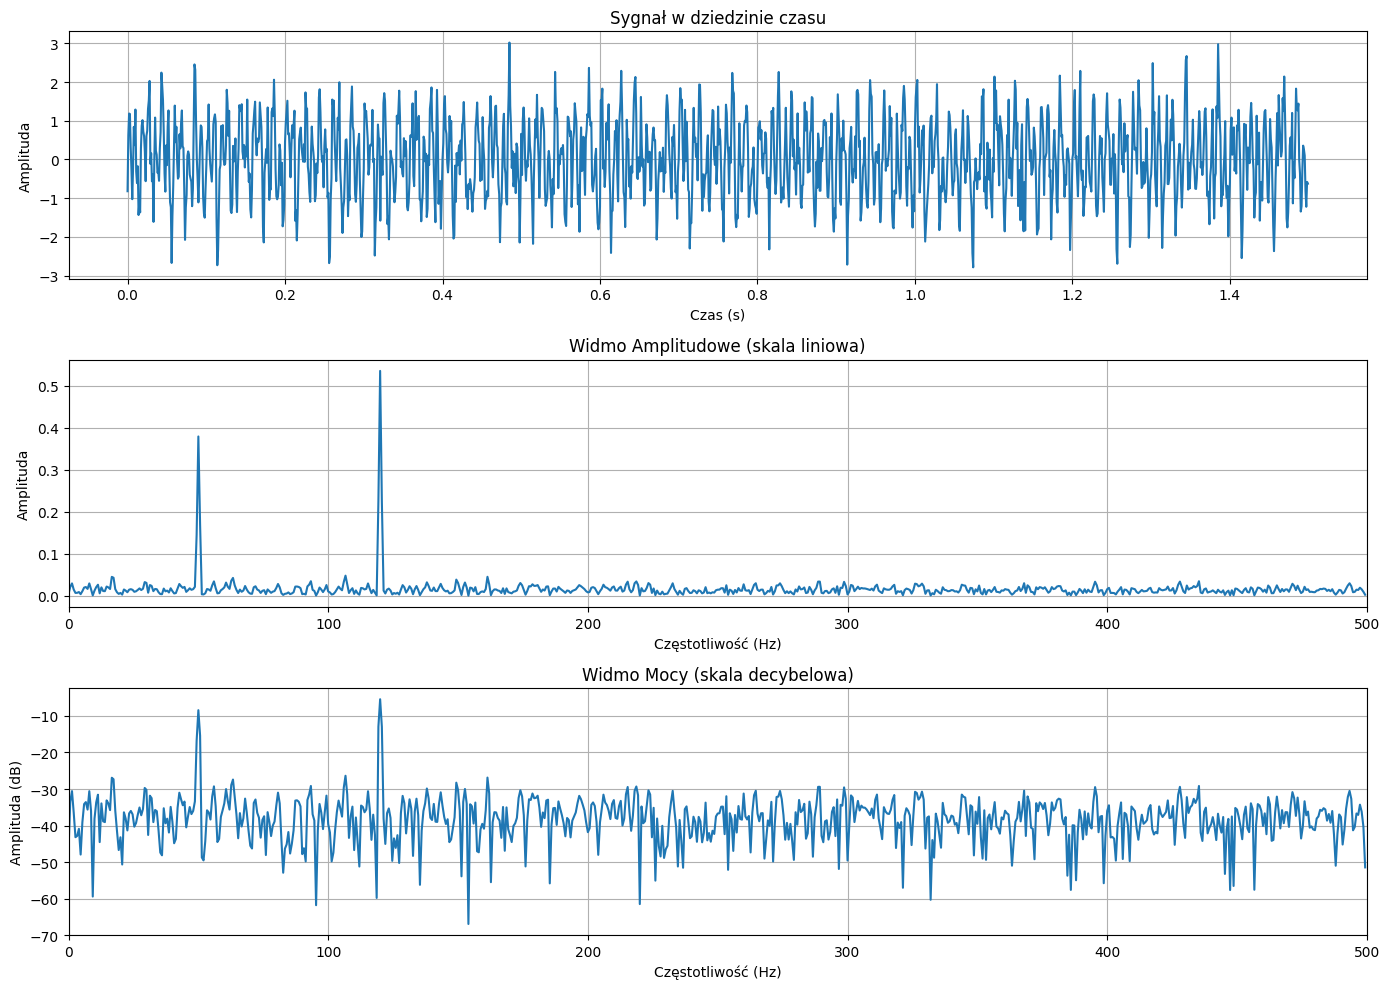

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ustawienia i Generowanie Sygnału Testowego ---
# Parametry sygnału
Fs = 1000       # Częstotliwość próbkowania (1000 Hz)
T = 1/Fs        # Okres próbkowania
L = 1500        # Długość sygnału (liczba próbek)
t = np.arange(L) * T # Wektor czasu

# Składowe częstotliwościowe sygnału
f1 = 50.0       # Częstotliwość 1 (50 Hz)
f2 = 120.0      # Częstotliwość 2 (120 Hz)

# Generowanie sygnału (dwie składowe sinusoidalne plus szum)
A1 = 0.7        # Amplituda 1
A2 = 1.0        # Amplituda 2
noise = 0.5 * np.random.randn(L) # Szum Gaussowski

signal_time = A1 * np.sin(2 * np.pi * f1 * t) + \
              A2 * np.sin(2 * np.pi * f2 * t) + \
              noise

# --- 2. Analiza Pasmo-Amplitudowa (FFT) ---

# Zastosowanie Okna (opcjonalne, ale zalecane)
# Okno Hamminga minimalizuje wyciek widmowy.
window = np.hamming(L)
signal_windowed = signal_time * window

# Szybka Transformata Fouriera (FFT)
Y = np.fft.fft(signal_windowed)

# Obliczenie widma dwustronnego (moduł z wyników FFT)
P2 = np.abs(Y / L)

# Przekształcenie widma dwustronnego na jednostronne (dla sygnału rzeczywistego)
P1 = P2[:L//2] # Bierzemy tylko pierwszą połowę (do częstotliwości Nyquista)
P1[1:-1] = 2 * P1[1:-1] # Mnożymy przez 2, ponieważ energia jest rozłożona na obie strony

# Wektor częstotliwości
f = Fs * np.arange(L//2) / L


# --- 3. Wizualizacja Wyników ---
plt.figure(figsize=(14, 10))

# 3a. Wykres w Dziedzinie Czasu
plt.subplot(3, 1, 1)
plt.plot(t, signal_time)
plt.title('Sygnał w dziedzinie czasu')
plt.xlabel('Czas (s)')
plt.ylabel('Amplituda')
plt.grid(True)


# [Image of signal in time domain]


# 3b. Widmo Amplitudowe (skala liniowa)
plt.subplot(3, 1, 2)
plt.plot(f, P1)
plt.title('Widmo Amplitudowe (skala liniowa)')
plt.xlabel('Częstotliwość (Hz)')
plt.ylabel('Amplituda')
plt.xlim([0, Fs/2]) # Ograniczamy do częstotliwości Nyquista
plt.grid(True)

# 3c. Widmo Mocy (skala dB - decybele)
plt.subplot(3, 1, 3)
# Przekształcenie amplitudy na decybele (z małym offsetem, by uniknąć log(0))
P1_dB = 20 * np.log10(P1 + 1e-10) 
plt.plot(f, P1_dB)
plt.title('Widmo Mocy (skala decybelowa)')
plt.xlabel('Częstotliwość (Hz)')
plt.ylabel('Amplituda (dB)')
plt.xlim([0, Fs/2])
plt.grid(True)

plt.tight_layout()
plt.show()